In [3]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
from CNN_helper_function import get_labels, eval_model

warnings.filterwarnings('ignore')

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

print(f"Tensorflow Version: {tf.__version__}")

# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

seed = 42
tf.random.set_seed(seed)

Tensorflow Version: 2.15.0


2025-02-02 17:16:56.225163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:16:56.270395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:16:56.270654: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
!nvidia-smi

Sun Feb  2 17:17:00 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   20C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Found 19675 files belonging to 2 classes.


2025-02-02 17:17:45.533001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:17:45.554097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 17:17:45.554385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

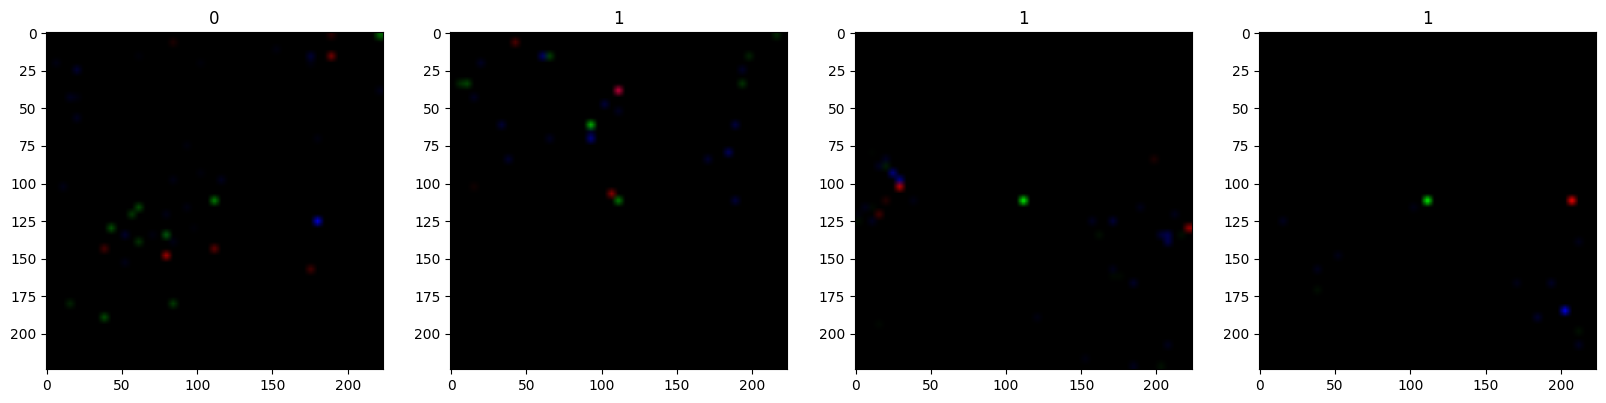

In [5]:
data_dir = '/teamspace/studios/this_studio/all/EFlow Images/rgb_images_data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 70,
                                                   image_size = (224,224))

scaled_data = data.map(lambda x, y: (x/255, y))

data_iterator = scaled_data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [6]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Loading VGG16 Model without the fully connected layers and making weights untrainable

In [7]:
vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

for layer in vgg16.layers:
    layer.trainable = False

In [8]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Adding Flatten and Dense layers to get Prediction

In [9]:
x = Conv2D(128, (3,3), 1, activation = 'relu')(vgg16.output)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=vgg16.input, outputs=predictions)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [13]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/VGG16_Classifier_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30


2025-02-02 17:19:15.191772: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-02-02 17:19:34.221403: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f658406e500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 17:19:34.221450: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-02 17:19:34.227871: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738516774.354573   19890 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - 88s 340ms/step - loss: 0.9032 - accuracy: 0.5667 - precision_1: 0.5705 - recall_1: 0.5071 - auc_1: 0.5843 - true_positives_1: 3464.0000 - false_positives_1: 2608.0000 - true_negatives_1: 4351.0000 - false_negatives_1: 3367.0000 - val_loss: 0.6532 - val_accuracy: 0.6092 - val_precision_1: 0.7228 - val_recall_1: 0.3991 - val_auc_1: 0.6756 - val_true_positives_1: 811.0000 - val_false_positives_1: 311.0000 - val_true_negatives_1: 1577.0000 - val_false_negatives_1: 1221.0000
Epoch 2/30
197/197 [==============================] - 66s 337ms/step - loss: 0.6597 - accuracy: 0.6054 - precision_1: 0.6189 - recall_1: 0.5292 - auc_1: 0.6484 - true_positives_1: 3615.0000 - false_positives_1: 2226.0000 - true_negatives_1: 4733.0000 - false_negatives_1: 3216.0000 - val_loss: 0.6376 - val_accuracy: 0.6421 - val_precision_1: 0.6294 - val_recall_1: 0.7337 - val_auc_1: 0.7046 - val_true_positives_1: 1474.0000 - val_false_positives_1: 868.0000 - val_true_negatives_

In [ ]:
# model.save(os.path.join('EFlow Images','VGG_Classifier2.keras'))

In [14]:
test_eval = model.evaluate(test)

28/28 [==============================] - 11s 249ms/step - loss: 0.6983 - accuracy: 0.6770 - precision_1: 0.7090 - recall_1: 0.6061 - auc_1: 0.7461 - true_positives_1: 597.0000 - false_positives_1: 245.0000 - true_negatives_1: 730.0000 - false_negatives_1: 388.0000


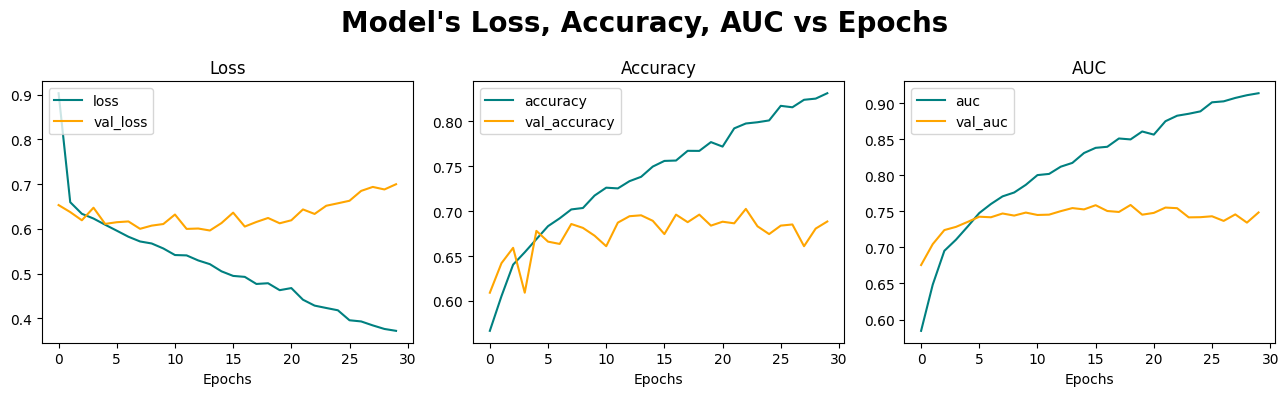

In [15]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(hist.history['loss'], color='teal', label='loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(hist.history['auc_1'], color='teal', label='auc')
axs[2].plot(hist.history['val_auc_1'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('VGG16_Classifier_trainingMetrics.png', dpi = 300)
plt.show()

In [16]:
print(f"Best Obtained Loss: {hist.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.3722776174545288
Best Obtained Accuracy: 83.14%
Best Obtained Validation Accuracy: 68.85%


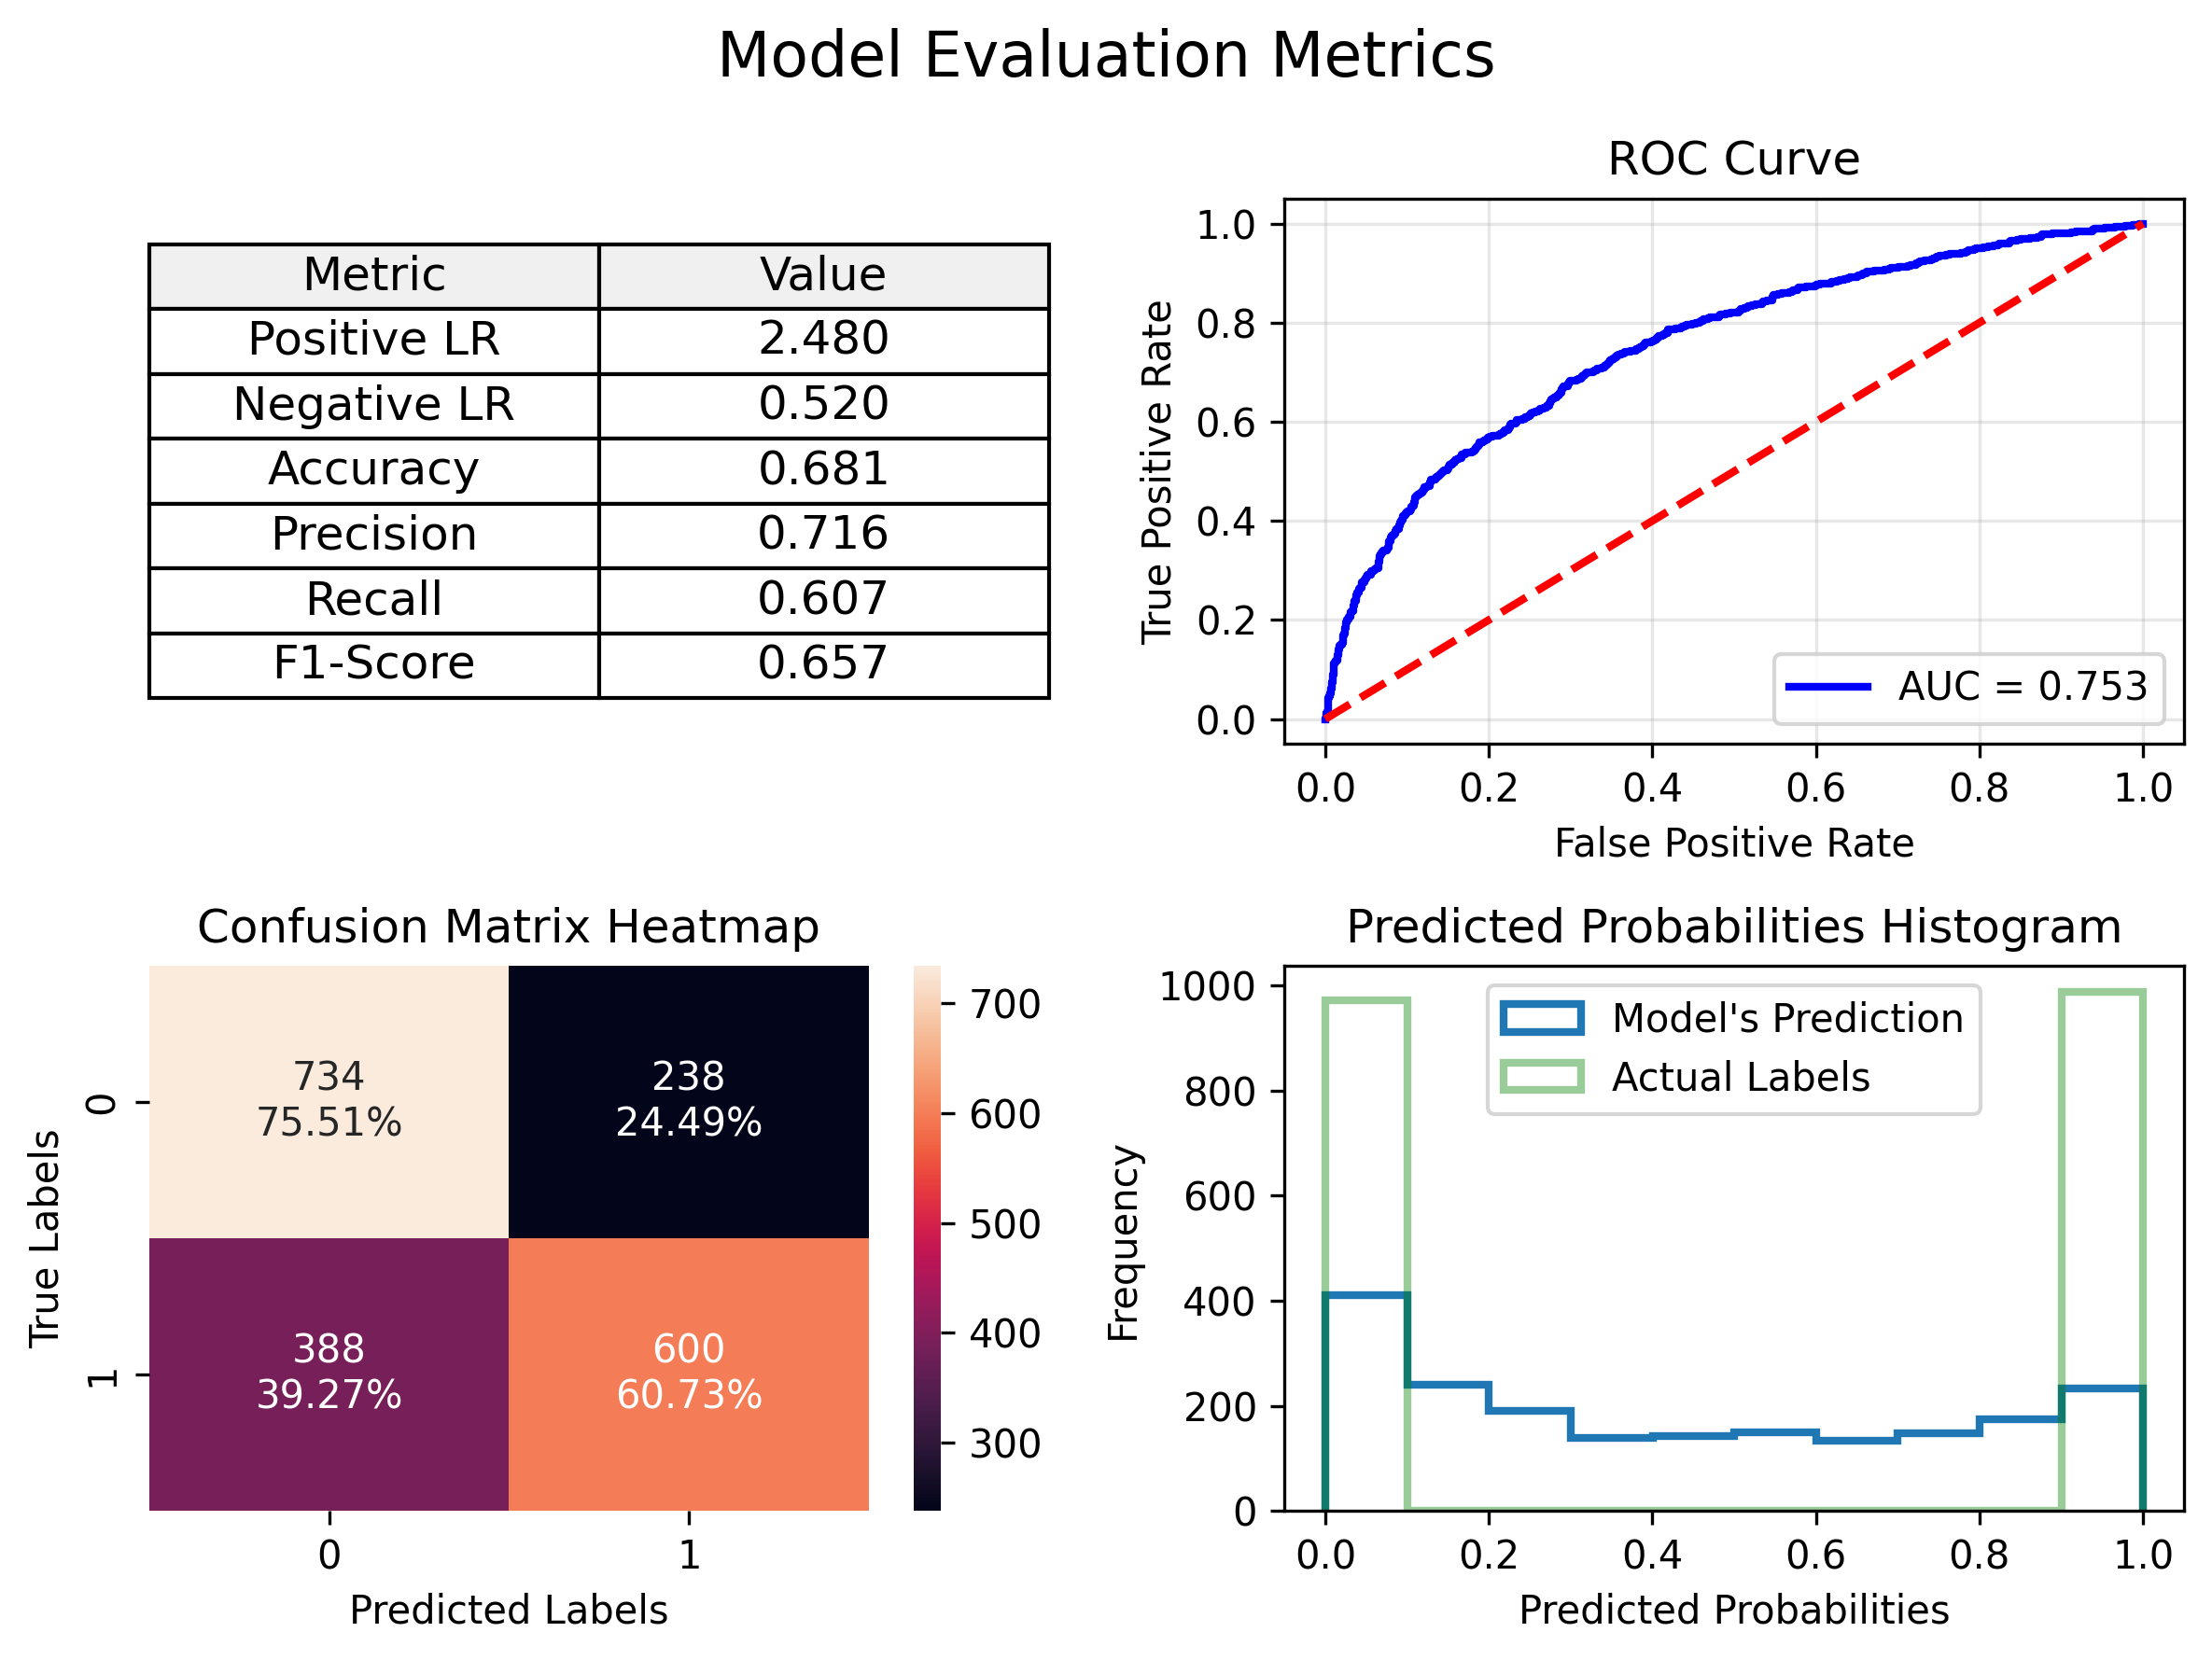

In [17]:
y_test_true, y_test_pred_prob = get_labels(model, test)
y_test_pred_label = [1 if (y_pred >= 0.5) else 0 for y_pred in y_test_pred_prob]
eval_model(y_test_true, y_test_pred_prob, y_test_pred_label, save_fig = False, save_fig_path = 'VGG16_Classifier_Metrics.png')